In [1]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# import apertls

In [2]:
path_lines = Path('../../injection_lines')
line = xt.Line.from_json(path_lines / 'sps_with_aperture_inj_q20.json')
#line = xt.Line.from_json(path_lines / 'injection_thin_approx_ap_with_deferred_expressions.json')
#line = xt.Line.from_json(path_lines / 'sps_lhc_q20_rf_with_ap.json')

#Set cavitiy voltages correctly
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

tw_ref = line.twiss4d()

for name in line.element_names:
    cls = line[name].__class__.__name__
    if cls.startswith('Multipole') or cls.startswith('Limit') or cls.startswith('ThinSliceQuadrupole') or cls.startswith('Quadrupole'):
        #Dogleg in LSS5 for extraction
        if 'qd.51710' in name:
            line[name].shift_y = -5.273e-3
        elif 'qfa.51810' in name:
            line[name].shift_y = -17.369e-3
        elif 'qd.51910' in name:
            line[name].shift_y = -5.273e-3
        #Dogleg in LSS1 for injection
        elif 'qd.11710' in name:   #Hannes Thesis says qda.
            line[name].shift_x = -4.80e-3
        elif 'qf.11810' in name:   #Hannes Thesis says qfa.
            line[name].shift_x = -2.97e-3
        elif 'qda.11910' in name:
            line[name].shift_x = -4.80e-3

Loading line from dict:   0%|          | 0/17781 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Iteration 0, x_rms: 3.97e-03 -> 1.21e-04, y_rms: 1.54e-03 -> 2.85e-04
Iteration 1, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.85e-04 -> 2.81e-04
Iteration 2, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.81e-04 -> 2.79e-04
Iteration 3, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.79e-04 -> 2.78e-04
Iteration 4, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.78e-04 -> 2.77e-04
Iteration 5, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 6, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 7, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 8, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 9, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04


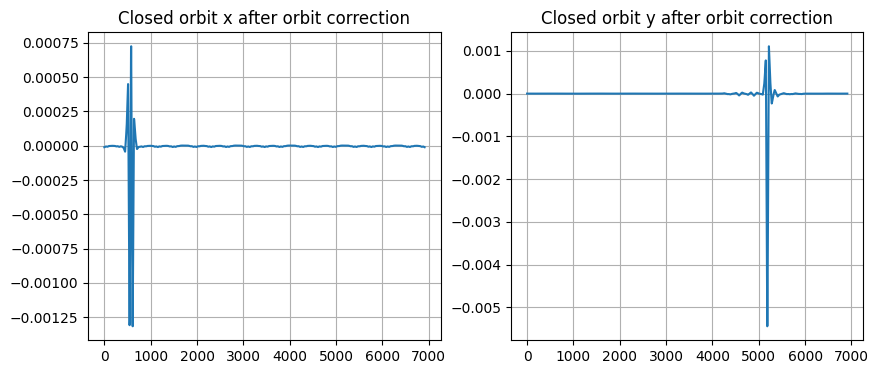

In [3]:
tt = line.get_table()
tw = line.twiss()

#Orbit correction
tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
line.steering_monitors_x = tt_monitors.name
line.steering_monitors_y = tt_monitors.name

tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]

orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=5, n_iter=10)

#Plot orbits to verify
tw = line.twiss()
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(tw.s, tw.x)
ax[0].set_title('Closed orbit x after orbit correction')
ax[0].grid()
ax[1].plot(tw.s, tw.y)
ax[1].set_title('Closed orbit y after orbit correction')
ax[1].grid()

In [4]:
try:
    acos = np.acos
except AttributeError:
    acos = np.arccos

def circle(radius, x_0, y_0, t):
    x = x_0 + radius*np.cos(t)
    y = y_0 + radius*np.sin(t)

    return x, y

def circle_vertical_coord(radius, x_0, y_0, x):
    t = acos((x-x_0)/radius)
    y = y_0 + radius*np.sin(t)

    return y

def straight_line(alpha, x_0, y_0, x):
    return alpha*(x-x_0) + y_0

def get_sagitta_effect_on_aperture(s, length, bending_radius, offset_middle_dipole, s_start_dipole = 0):
    #center of the bending circle
    s0 = s_start_dipole + length/2 
    x0 = -(bending_radius-offset_middle_dipole)

    #getting x position for that circle
    x = circle_vertical_coord(bending_radius, s0, x0, s)

    return x

In [5]:
def make_sagitta_dipole_apertures(x_orbits, aper_element):
    aperture_slices = []

    for x_pos in x_orbits:
        aper_pos = aper_element.copy()
        #aper_pos = make_non_replica_element(aper_element)
        aper_pos.shift_x = -x_pos
        aperture_slices.append(aper_pos)

    return np.array(aperture_slices)

def generate_aperture_slices_names(name_element, nb_slices):
    slices_names = []

    for i in range(nb_slices):
        slices_names.append(f'{name_element}..{i}_aper2')
        #slices_names.append(f'{name_element}_aper..{i}')

    return slices_names

In [6]:
env = line.env

nb_slices = 11

#Defining bending radius
R_mba = 1/line['mba.10030'].k0
R_mbb = 1/line['mbb.10070'].k0
assert R_mba == R_mbb
bending_radius = 1/line['mba.10030'].k0

#Defining magnetic length which is considered as the length of the magnet
assert line['mba.10030'].length == line['mbb.10070'].length
length = line['mba.10030'].length

#Sagitta offsets (predefined)
offset_end_dipole=4.4e-3
offset_middle_dipole=2.2e-3

#mba magnets
names_mba = tt.rows['mba.*'].name
positions_mba = tt.rows['mba.*'].s
s_positions_generic_mba = np.linspace(0, length, nb_slices)
x_orbits_mba = get_sagitta_effect_on_aperture(s_positions_generic_mba, length, bending_radius, offset_middle_dipole)
dim_x_mba = 0.076
dim_y_mba = 0.0193
# mba_sagitta_apertures = [xt.LimitRect(min_x=-dim_x_mba, max_x=dim_x_mba, min_y=-dim_y_mba, max_y=dim_y_mba, shift_x=-x_orbits_mba[i], shift_y=0) for i in range(len(x_orbits_mba))]
mba_sagitta_apertures = [xt.LimitRect(min_x=-dim_x_mba-x_orbits_mba[i], max_x=dim_x_mba-x_orbits_mba[i], min_y=-dim_y_mba, max_y=dim_y_mba) for i in range(len(x_orbits_mba))]

#mbb magnets
names_mbb = tt.rows['mbb.*'].name
positions_mbb = tt.rows['mbb.*'].s
s_positions_generic_mbb = np.linspace(0, length, nb_slices)
x_orbits_mbb = get_sagitta_effect_on_aperture(s_positions_generic_mbb, length, bending_radius, offset_middle_dipole)
dim_x_mbb = 0.0645
dim_y_mbb = 0.0267
# mbb_sagitta_apertures = [xt.LimitRect(min_x=-dim_x_mbb, max_x=dim_x_mbb, min_y=-dim_y_mbb, max_y=dim_y_mbb, shift_x=-x_orbits_mbb[i], shift_y=0) for i in range(len(x_orbits_mbb))]
mbb_sagitta_apertures = [xt.LimitRect(min_x=-dim_x_mbb-x_orbits_mbb[i], max_x=dim_x_mbb-x_orbits_mbb[i], min_y=-dim_y_mbb, max_y=dim_y_mbb) for i in range(len(x_orbits_mbb))]

insertions = []

for i in range(len(names_mba)):
    s_positions = np.linspace(positions_mba[i], positions_mba[i] + length, nb_slices)
    aperture_slices_names = generate_aperture_slices_names(names_mba[i], nb_slices)

    for nn, ee, ss in zip(aperture_slices_names, mba_sagitta_apertures, s_positions):
        env.elements[nn] = ee.copy()
        insertions.append(env.place(nn, at=ss))


for i in range(len(names_mbb)):
    s_positions = np.linspace(positions_mbb[i], positions_mbb[i] + length, nb_slices)
    aperture_slices_names = generate_aperture_slices_names(names_mbb[i], nb_slices)

    # for nn, ee, ss in zip(aperture_slices_names, mbb_sagitta_apertures, s_positions):
    #     s_positions = np.linspace(positions_mbb[i], positions_mbb[i] + length, nb_slices)
    #     aperture_slices_names = generate_aperture_slices_names(names_mbb[i], nb_slices)

    for nn, ee, ss in zip(aperture_slices_names, mbb_sagitta_apertures, s_positions):
        env.elements[nn] = ee.copy()
        insertions.append(env.place(nn, at=ss))

line.insert(insertions)

Slicing line:   0%|          | 0/15184 [00:00<?, ?it/s]

In [7]:
def move_list_element_n_backwards(lst, elems, n):
    for elem in elems:
        idx = lst.index(elem)
        if idx < n or idx >= len(lst):
            raise IndexError(f'Index {idx} of element {elem} out of valid range for moving back {n} steps.')

        elem_check = lst.pop(idx)
        assert elem == elem_check
        lst.insert(idx-n, elem)
    return lst

In [8]:
tt = line.get_table()
line.discard_tracker()

#remove replica apertures
replica_apertures_mb_names= tt.rows['^mb[ab]\\.[^_]*_aper\\.\\.\\d+$'].name
for name in replica_apertures_mb_names:
    idx = line.element_names.index(name)
    line.element_names.pop(idx)
    del line.element_dict[name]

#Move last aperture of each dipole before exit fringe map
exit_mb_apertures = tt.rows['^mb[ab]\\..*\\.\\.10_aper2$'].name
line.element_names = move_list_element_n_backwards(line.element_names, list(exit_mb_apertures), 2)

In [13]:
line.to_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta3.json')

In [10]:
%matplotlib tk
line_thick = xt.Line.from_json('../../injection_lines/injection_thick_approx_ap.json')
plotter = apertls.InteractiveAperturePlotter(line, line_thick)

Loading line from dict:   0%|          | 0/7477 [00:00<?, ?it/s]

Done loading line from dict.           


2025-04-22 15:57:55.786 python[19405:6925998] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-22 15:57:55.786 python[19405:6925998] +[IMKInputSession subclass]: chose IMKInputSession_Modern
